## 06. PyTorch Experiment Tracking

- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/07_pytorch_experiment_tracking.ipynb

Different ways to track machine learning experiments

![Alt text](image-3.png)

![Alt text](image-4.png)

### 0. Getting setup

In [1]:
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
import sys
import os

In [4]:
os.getcwd()

'/Users/sguys99/Desktop/project/pytorch-study/zero-to-mastery'

In [5]:
from going_modular import data_setup, engine

/Users/sguys99/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

### 1. Get data

In [8]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

### 2. Create Datasets and DataLoaders

앞에서 만든 create_dataloaders() 함수를 사용할 것이다.   
여기서  torchvision.models를 사용하여 전이학습을 진행할 예정이기 때문에 모델에 맡는 변환 작업을 진행해야한다.   

이미지 텐서를 변환하는 방법은 두가지가 있다.  
- Manually created transforms using torchvision.transforms.
- Automatically created transforms using torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms().
    - Where MODEL_NAME is a specific torchvision.models architecture, MODEL_WEIGHTS is a specific set of pretrained weights and DEFAULT means the "best available weights".

위 방법은 06 챕터에서 실시한 것이다.  

먼저 torchvision.transforms 파이프라인을 수동으로 생성하는 예제를 살펴보겠습니다(이 방법으로 생성하면 다양한 사용자 정의가 가능하지만 변환 결과가 전이학습 모델과 일치하지 않으면 잠재적으로 성능이 저하될 수 있습니다).

우리가 확인해야 할 주요 수동 변환은 모든 이미지가 ImageNet 형식으로 정규화되어 있는지 여부입니다(이는 사전 학습된 torchvision.models가 모두 ImageNet에서 사전 학습되었기 때문입니다).

예를 들어 다음과 같이 말이다. 

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

#### 2.1 Create DataLoaders using manually created transforms

In [9]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x166c53fd0>,
 ['pizza', 'steak', 'sushi'])

#### 2.2 Create DataLoaders using automatically created transforms

In [10]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x166e43220>,
 ['pizza', 'steak', 'sushi'])

### 3. Getting a pretrained model, freezing the base layers and changing the classifier head

여러 모델링 실험을 실행하고 추적하기 전에 하나의 실험을 실행하고 추적하는 것이 어떤지 살펴봅시다.

데이터가 준비되었으므로 다음으로 필요한 것은 모델입니다.

torchvision.models.efficientnet_b0() 모델을 다운로드하여, 우리 데이터로 사용할 수 있도록  준비해보자.

In [11]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

In [12]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

이제 사전 학습된 모델을 특징 extractor 모델로 전환해 보겠습니다.  
기본적으로 모델의 기본 레이어를 고정하고(입력 이미지에서 특징을 추출하는 데 사용할 것입니다) 작업 중인 클래스의 수에 맞게 분류기 헤드(출력 레이어)를 변경합니다(피자, 스테이크, 초밥의 세 가지 클래스가 있습니다).

참고: 특징 추출기 모델을 만드는 아이디어(여기서 하는 일)는 06편에서 더 자세히 다루었습니다.

In [13]:
for param in model.features. parameters():
    param.requires_grad = False
    
set_seeds()

model.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features = len(class_names),
              bias = True).to(device)) 

In [14]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

![Alt text](image-5.png)

### 4. Train model and track results

이제 손실함수와 옵티마이저를 준비하자.

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

#### Adjust train() function to track results with SummaryWriter()¶

이전에는 모델마다 하나씩 여러 개의 파이썬 딕셔너리를 사용하여 모델링 실험을 추적했습니다.

하지만 실험을 몇 개 이상 실행하는 경우 이 작업이 복잡해질 수 있다는 것을 상상할 수 있습니다.

걱정하지 마세요. 더 나은 옵션이 있으니까요!   

PyTorch의 torch.utils.tensorboard.SummaryWriter() 클래스를 사용하여 모델 학습 진행 상황의 다양한 부분을 파일에 저장할 수 있습니다.
기본적으로 SummaryWriter() 클래스는 모델에 대한 다양한 정보를 log_dir 매개변수로 설정된 파일에 저장합니다.
log_dir의 기본 위치는 runs/CURRENT_DATETIME_HOSTNAME 아래에 있으며, 여기서 호스트 이름은 사용자 컴퓨터 이름입니다.
물론 실험이 추적되는 위치를 변경할 수 있습니다(파일 이름은 원하는 대로 사용자 지정 가능).

SummaryWriter()의 출력은 TensorBoard 형식으로 저장됩니다.
TensorBoard는 TensorFlow 딥 러닝 라이브러리의 일부로, 모델의 다양한 부분을 시각화하는 데 탁월한 방법입니다.
모델링 실험 추적을 시작하기 위해 기본 SummaryWriter() 인스턴스를 만들어 보겠습니다.

In [17]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

이제 writer를 사용하려면 새로운 훈련 루프를 작성하거나 05에서 만든 기존 train() 함수를 조정할 수 있습니다.  
후자를 선택하겠습니다.  

engine.py에서 train() 함수를 가져와서 writer를 사용하도록 조정하겠습니다.   
구체적으로, train() 함수에 모델의 훈련 및 테스트 손실과 정확도 값을 기록하는 기능을 추가하겠습니다.  
writer.add_scalars(main_tag, tag_scalar_dict)를 사용하여 이 작업을 수행할 수 있습니다:  

- main_tag(string): 추척할 스칼라의 이름(ex: 'Accuracy')
- tag_scalar_dict(dict): 추적할 딕셔너리 값(ex: {"train_loss": 0.3454})
* 손실 및 정확도 값은 일반적으로 스칼라(단일 값)이기 때문에 이 메서드를 add_scalars()라고 합니다.

값 추적이 끝나면 writer.close()를 호출하여 추적할 값 찾기를 중단하라고 지시합니다.

train() 수정을 시작하기 위해 engine.py에서 train_step() 및 test_step()도 임포트합니다.

참고: 코드의 거의 모든 곳에서 모델에 대한 정보를 추적할 수 있습니다. 하지만 모델이 훈련하는 동안(훈련/테스트 루프 내에서) 실험을 추적하는 경우가 많습니다.

또한, torch.utils.tensorboard.SummaryWriter() 클래스에는 모델의 계산 그래프를 추적하는 add_graph()와 같이 모델/데이터에 대한 다양한 정보를 추적하는 여러 가지 메서드가 있습니다. 더 많은 옵션은 SummaryWriter() 설명서를 참조하세요.   

In [18]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

In [19]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device) -> Dict[str, List]:
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device
                                           )
        
        test_loss, test_acc = test_step(model = model,
                                        dataloader=test_dataloader,
                                        loss_fn = loss_fn,
                                        device=device
                                        )
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        
        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    writer.close()
    
    return results

5 epochs 만 시도해보자.

In [20]:
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0883 | train_acc: 0.4180 | test_loss: 0.8914 | test_acc: 0.6818


 20%|██        | 1/5 [00:38<02:35, 38.80s/it]

Epoch: 2 | train_loss: 0.8937 | train_acc: 0.6641 | test_loss: 0.8082 | test_acc: 0.7746


 40%|████      | 2/5 [01:17<01:56, 38.97s/it]

Epoch: 3 | train_loss: 0.7450 | train_acc: 0.8438 | test_loss: 0.7433 | test_acc: 0.7538


 60%|██████    | 3/5 [01:56<01:18, 39.00s/it]

Epoch: 4 | train_loss: 0.7797 | train_acc: 0.6992 | test_loss: 0.6849 | test_acc: 0.8040


 80%|████████  | 4/5 [02:36<00:39, 39.05s/it]

Epoch: 5 | train_loss: 0.6322 | train_acc: 0.7695 | test_loss: 0.6428 | test_acc: 0.8362


100%|██████████| 5/5 [03:15<00:00, 39.01s/it]


In [21]:
results

{'train_loss': [1.0882934033870697,
  0.8936692476272583,
  0.7449564561247826,
  0.7797180041670799,
  0.6321721002459526],
 'train_acc': [0.41796875, 0.6640625, 0.84375, 0.69921875, 0.76953125],
 'test_loss': [0.8914492925008138,
  0.808230459690094,
  0.7433455586433411,
  0.6849219004313151,
  0.6428378224372864],
 'test_acc': [0.6818181818181818,
  0.774621212121212,
  0.7537878787878788,
  0.8039772727272728,
  0.8361742424242425]}

### 5. View our model's results in TensorBoard

SummaryWriter() 클래스는 기본적으로 모델 결과를 runs/라는 디렉터리에 TensorBoard 형식으로 저장합니다.
TensorBoard는 모델과 데이터에 대한 정보를 보고 검사하기 위해 TensorFlow 팀에서 만든 시각화 프로그램입니다.
여러 가지 방법으로 TensorBoard를 볼 수 있습니다:

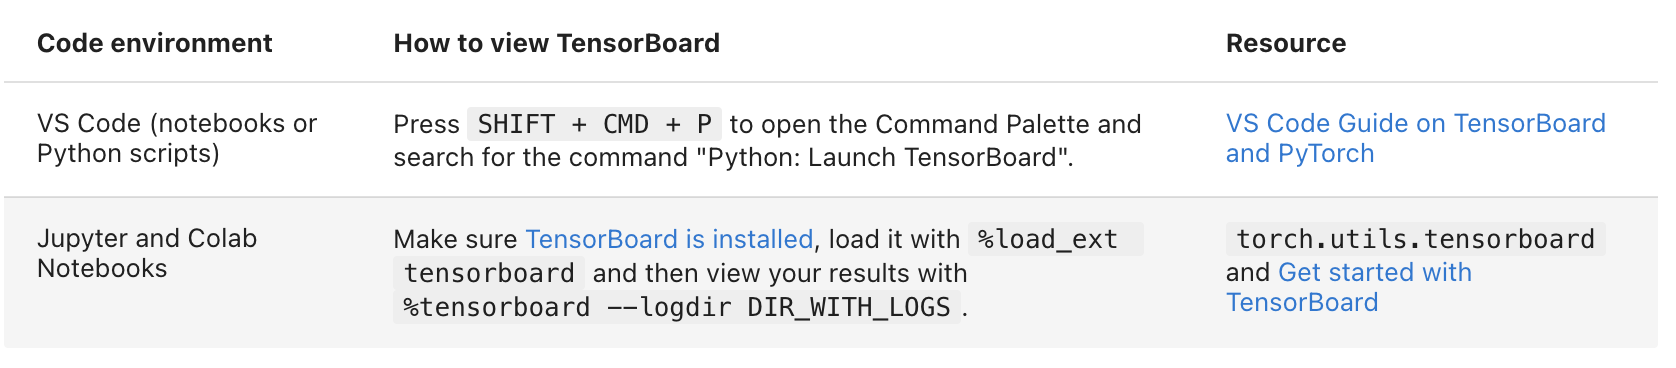

### 6. Create a helper function to build SummaryWriter() instances

SummaryWriter() 클래스는 다양한 정보를 log_dir 매개변수로 지정된 디렉터리에 기록합니다.

실험별로 사용자 정의 디렉터리를 생성하는 도우미 함수를 만드는 것은 어떨까요?

본질적으로 각 실험은 자체 로그 디렉터리를 갖게 됩니다.

- Experiment date/timestamp - when did the experiment take place?
- Experiment name - is there something we'd like to call the experiment?
- Model name - what model was used?
- Extra - should anything else be tracked?

In [22]:
def create_writer(experiment_name: str, 
                  model_name: str,
                  extra: str=None
                  )-> torch.utils.tensorboard.writer.SummaryWriter():
    from datetime import datetime
    import os
    
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [23]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_10_percent/effnetb0/5_epochs...


#### 6.1 Update the train() function to include a writer parameter

train() 함수에 writer 매개변수를 받을 수 있는 기능을 추가하여 train() 함수를 호출할 때마다 사용 중인 SummaryWriter() 인스턴스를 능동적으로 업데이트하는 것은 어떨까요?

예를 들어, 여러 가지 다른 모델에 대해 train()을 여러 번 호출하는 일련의 실험을 실행한다고 가정할 때, 각 실험마다 다른 라이터를 사용하면 좋을 것입니다.

실험당 하나의 작성자 = 실험당 하나의 로그 디렉터리.

train() 함수를 조정하기 위해 함수에 writer 매개 변수를 추가한 다음, 작가가 있는지 확인하고 작가가 있는 경우 해당 정보를 추적하는 코드를 추가하겠습니다.

In [24]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### 7. Setting up a series of modelling experiments

이전에는 다양한 실험을 실행하고 그 결과를 하나씩 검사했습니다.

하지만 여러 실험을 실행한 다음 결과를 한꺼번에 검사할 수 있다면 어떨까요?

#### 7.1 What kind of experiments should you run?

실행할 수 있는 실험에는 실제로 제한이 없기 때문입니다.

이러한 자유로움은 머신러닝이 흥미로우면서도 두려운 이유이기도 합니다.

바로 이 지점에서 과학자 코트를 입고 머신 러닝 실무자의 모토인 '실험, 실험, 실험'을 기억해야 합니다!

모든 하이퍼파라미터는 다른 실험을 위한 출발점이 됩니다:

- 에포크 수를 변경합니다.
- 레이어/숨겨진 단위 수를 변경합니다.
- 데이터 양을 변경합니다.
- 학습 속도를 변경합니다.
- 다양한 종류의 데이터 증강을 시도합니다.
- 다른 모델 아키텍처를 선택합니다.

연습하고 다양한 실험을 실행하다 보면 무엇이 모델에 도움이 될지 직관적으로 알 수 있게 됩니다.  

일부러 '그럴 수도 있다'고 말한 이유는 장담할 수 없기 때문입니다.  

하지만 일반적으로 쓰라린 교훈(AI 세계에서 중요한 에세이이므로 두 번이나 언급했습니다)에 비추어 볼 때 일반적으로 모델이 클수록(학습 가능한 매개변수가 많을수록), 데이터가 많을수록(학습할 기회가 많을수록) 성능이 더 좋아집니다.  

하지만 머신 러닝 문제에 처음 접근하는 경우, 작은 규모로 시작하여 효과가 있으면 규모를 확장하세요.  

첫 번째 실험 배치는 실행하는 데 몇 초에서 몇 분 이상 걸리지 않아야 합니다.  

실험을 빠르게 진행할수록 무엇이 작동하지 않는지 더 빨리 파악할 수 있고, 결과적으로 무엇이 작동하는지 더 빨리 파악할 수 있습니다.  

#### 7.2 What experiments are we going to run?

우리의 목표는 FoodVision Mini를 구동하는 모델을 개선하는 것입니다.    

본질적으로 우리의 이상적인 모델은 높은 수준의 테스트 세트 정확도(90% 이상)를 달성하면서도 추론(예측)을 훈련/수행하는 데 너무 오래 걸리지 않는 것입니다.

다양한 옵션이 있지만 간단하게 해보는 것은 어떨까요?  

다음의 조합을 시도해 보겠습니다:  

- 다른 데이터 양(피자, 스테이크, 스시의 10% 대 20%)
- 다른 모델(torchvision.models.efficientnet_b0 vs. torchvision.models.efficientnet_b2)
- 다른 훈련 시간(5 에포크 대 10 에포크)   
   
이를 세분화하면 다음과 같습니다:

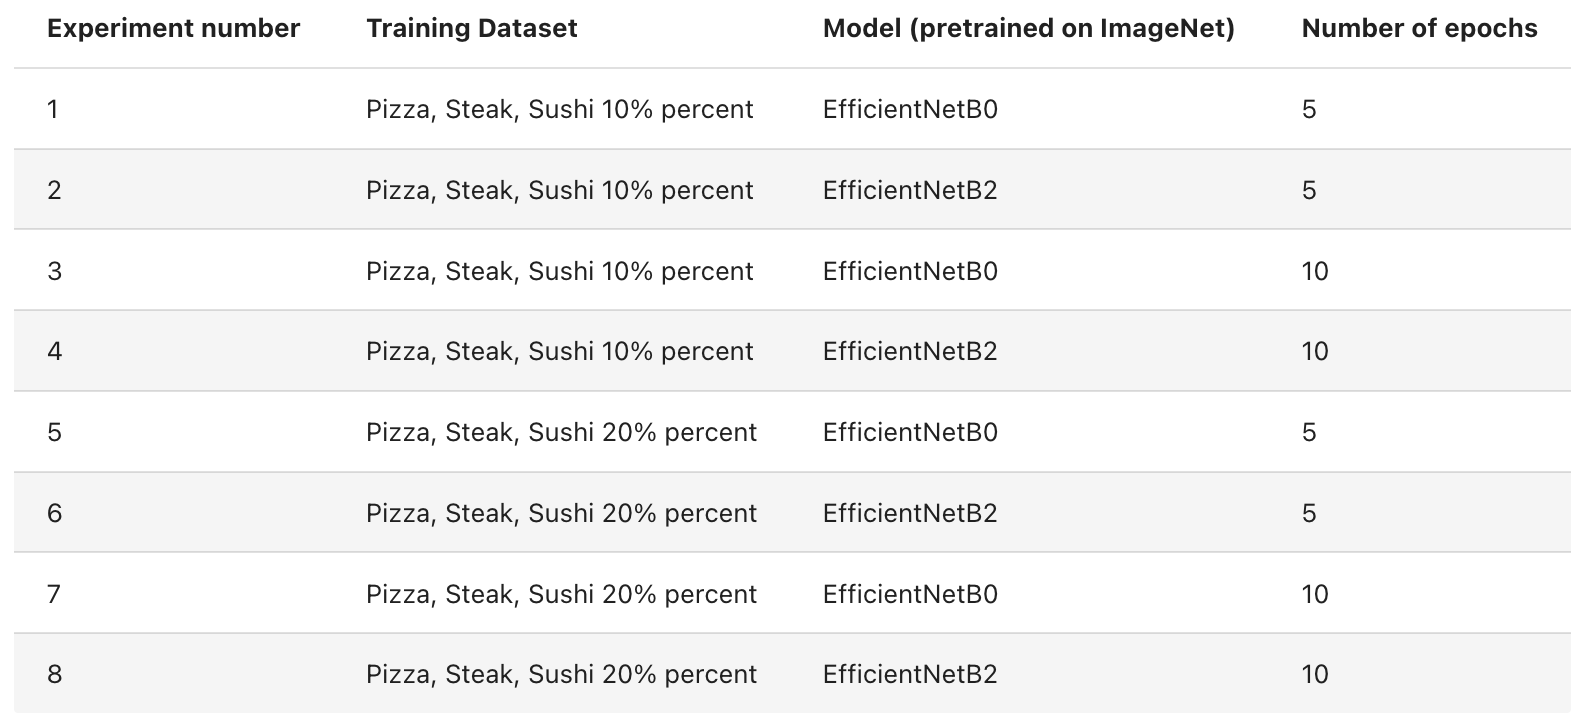

천천히 규모를 확장하는 과정을 주목하세요.  

실험을 진행할 때마다 데이터의 양, 모델 크기, 훈련 기간을 천천히 늘립니다.  

마지막 실험 8에서는 실험 1에 비해 두 배의 데이터, 두 배의 모델 크기, 두 배의 훈련 기간을 사용하게 됩니다.  

#### 7.3 Download different datasets

일련의 실험을 시작하기 전에 데이터 세트가 준비되었는지 확인해야 합니다.  

두 가지 형태의 훈련 세트가 필요합니다:

- Food101 피자, 스테이크, 스시 이미지 데이터의 10%가 포함된 훈련 세트(위에서 이미 만들었지만 완성도를 위해 다시 만들겠습니다).
- Food101 피자, 스테이크, 스시 이미지 데이터의 20%가 포함된 훈련 세트입니다.

일관성을 위해 모든 실험에서는 동일한 테스트 데이터 세트(10% 데이터 분할의 데이터 세트)를 사용합니다.

앞서 만든 download_data() 함수를 사용하여 필요한 다양한 데이터 세트를 다운로드하는 것으로 시작하겠습니다.

두 데이터 세트는 모두 코스 GitHub에서 사용할 수 있습니다:


In [25]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


데이터가 다운로드되었습니다!

이제 다양한 실험에 사용할 데이터의 파일 경로를 설정해 보겠습니다.

서로 다른 훈련 디렉터리 경로를 만들겠지만 모든 실험에서 동일한 테스트 데이터 세트(피자, 스테이크, 초밥 10%의 테스트 데이터 세트)를 사용하므로 테스트 디렉터리 경로는 하나만 필요합니다.

In [26]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


#### 7.4 Transform Datasets and create DataLoaders

In [27]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [28]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


#### 7.5 Create feature extractor models

이제 모델을 빌드한 시점이다.   
여기서는 두가지 feature extractor 모델을 생성할 것이다.   

- torchvision.models.efficientnet_b0() pretrained backbone + custom classifier head (EffNetB0 for short).
- torchvision.models.efficientnet_b2() pretrained backbone + custom classifier head (EffNetB2 for short).

이를 위해 06에서 했던 것처럼 기본 레이어(특징 레이어)를 고정하고 모델의 분류기 헤드(출력 레이어)를 문제에 맞게 업데이트할 것입니다.   

이전 장에서 EffNetB0의 분류기 헤드에 대한 in_features 매개변수가 1280이라는 것을 보았습니다(백본은 입력 이미지를 1280 크기의 특징 벡터로 변환합니다).   

EffNetB2는 레이어 수와 파라미터가 다르므로 그에 맞게 조정해야 합니다.   

참고: 다른 모델을 사용할 때마다 가장 먼저 검사해야 할 것 중 하나는 입력 및 출력 모양입니다. 이렇게 하면 올바른 출력 모양을 갖기 위해 입력 데이터를 준비하거나 모델을 업데이트해야 하는 방법을 알 수 있습니다.

torchinfo.summary()를 사용하여 input_size=(32, 3, 224, 224) parameter((32, 3, 224, 224)를 전달하면 EffNetB2의 입력 및 출력 모양을 찾을 수 있습니다. 즉, 단일 데이터 배치의 예시를 모델에 전달한 것입니다(예: batch_size, color_channels, height, width).

참고: 많은 최신 모델에서 다양한 크기의 입력 이미지를 처리할 수 있는 것은 torch.nn.AdaptiveAvgPool2d() 레이어 덕분이며, 이 레이어는 필요에 따라 주어진 입력의 출력 크기를 적응적으로 조정합니다. 이 레이어를 사용하여 다양한 크기의 입력 이미지를 torchinfo.summary() 또는 자체 모델에 전달하여 시도해 볼 수 있습니다.

EffNetB2의 최종레이어로 보내기 위한 입력 모델을 찾기 위해 다음을 수행한다.

1. torchvision.models.efficientnet_b2(pretr ained=True)의 인스턴스를 생성합니다.

2. torchinfo.summary()를 실행하여 다양한 입력 및 출력 모양을 확인합니다.  

3. EffNetB2의 분류기 부분의 state_dict()를 검사하고 가중치 행렬의 길이를 인쇄하여 in_features의 수를 출력합니다.

참고: effnetb2.classifier의 출력만 검사할 수도 있습니다.

In [29]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [30]:
# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


이제 EffNetB2 모델에 필요한 in_features 개수를 알았으니, EffNetB0 및 EffNetB2 특징 추출기 모델을 설정하기 위한 몇 가지 도우미 함수를 만들어 보겠습니다.  

이 함수는 다음과 같습니다:  

1. torchvision.models에서 기본 모델을 가져옵니다.    

2. 모델에서 기본 레이어를 고정합니다(requires_grad=False 설정).  

3. 무작위 시드를 설정합니다(이 작업을 수행할 필요는 없지만 일련의 실험을 실행하고 무작위 가중치로 새 레이어를 초기화하기 때문에 각 실험마다 무작위성이 비슷하기를 원합니다).  

4. 분류기 헤드를 변경합니다(문제에 맞게).   

5. 모델에 이름을 지정합니다(예: EffNetB0의 경우 "effnetb0").  

In [31]:
import torchvision
from torch import nn

In [32]:
OUT_FEATURES = len(class_names)
OUT_FEATURES

3

In [33]:
# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [34]:
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    for param in model.features.parameters():
        param.requires_grad = False
        
    set_seeds()
    
    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)
    
    model.name = 'effnetb2'
    print(f"[INFO] Created new {model.name} model.")
    return model

In [35]:
effnetb0 = create_effnetb0() 
effnetb0

[INFO] Created new effnetb0 model.


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [36]:

effnetb2 = create_effnetb2()

[INFO] Created new effnetb2 model.


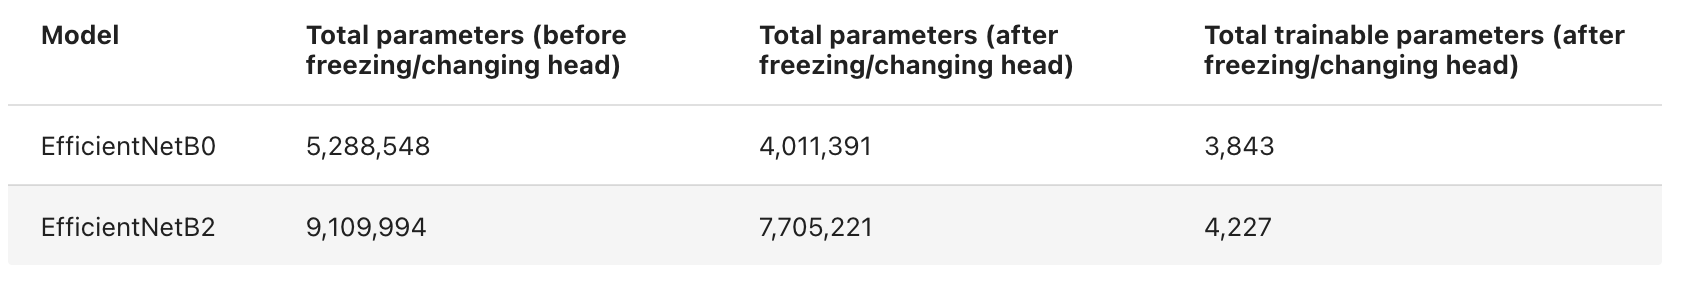

이렇게 하면 EffNetB2 모델의 백본이 피자, 스테이크, 스시 데이터를 표현할 수 있는 더 많은 기회를 얻게 됩니다.

하지만 각 모델(분류기 헤드)의 학습 가능한 파라미터는 크게 다르지 않습니다.

이러한 추가 매개변수가 더 나은 결과로 이어질까요?

두고 봐야 알겠죠...

참고: 실험 정신에 입각해, 여기서 하는 것과 비슷한 방식으로 torchvision.models의 거의 모든 모델을 사용해 볼 수 있습니다. 여기서는 EffNetB0과 EffNetB2만 예시로 선택했습니다. torchvision.models.convnext_tiny() 또는 torchvision.models.convnext_small() 같은 함수를 사용해 볼 수도 있습니다.

#### 7.6 Create experiments and set up training code

We'll start by creating two lists and a dictionary:  

1. A list of the number of epochs we'd like to test ([5, 10])  
2. A list of the models we'd like to test (["effnetb0", "effnetb2"])  
3. A dictionary of the different training DataLoaders

In [37]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

리스트와 딕셔너리가 생성되었습니다!

이제 다양한 옵션 각각을 반복하고 다양한 조합을 시도하는 코드를 작성할 수 있습니다.

또한 각 실험이 끝날 때마다 모델을 저장하여 나중에 최상의 모델을 다시 로드하여 예측에 사용할 수 있습니다.

1. 무작위 시드를 설정합니다(실험 결과를 재현할 수 있도록, 실제로는 최대 3개의 다른 시드에서 동일한 실험을 실행하고 결과의 평균을 구할 수 있습니다).

2. 다양한 실험 번호를 추적합니다(주로 예쁜 인쇄물을 만들기 위한 것입니다).

3. 각기 다른 훈련용 데이터로더에 대해 train_dataloaders 딕셔너리 항목을 반복합니다.

4. 에포크 번호 목록을 반복합니다.

5. 다양한 모델 이름 목록을 반복합니다.

6. 현재 실행 중인 실험에 대한 정보 인쇄물을 생성합니다(무슨 일이 일어나고 있는지 알 수 있도록).

7. 어떤 모델이 대상 모델인지 확인하고 새 EffNetB0 또는 EffNetB2 인스턴스를 생성합니다(모든 모델이 동일한 관점에서 시작하도록 각 실험마다 새 모델 인스턴스를 생성합니다).

8. 각각의 새로운 실험에 대해 새로운 손실 함수(torch.nn.CrossEntropyLoss())와 최적화기(torch.optim.Adam(params=model.parameters(), lr=0.001))를 생성합니다.

9. 수정된 train() 함수를 사용하여 적절한 세부 정보를 writer 파라미터에 전달하여 모델을 훈련합니다.

10. 훈련된 모델을 utils.py의 save_model()을 사용하여 적절한 파일 이름으로 파일에 저장합니다.

In [38]:
%%time
from going_modular.utils import save_model

set_seeds(seed = 42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    
    for epochs in num_epochs:
        
        for model_name in models:
            
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  
            
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
                
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
            
            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")
            

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_10_percent/effnetb0/5_epochs...


 20%|██        | 1/5 [00:24<01:38, 24.74s/it]

Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.9296 | test_acc: 0.4470


 40%|████      | 2/5 [00:49<01:14, 24.74s/it]

Epoch: 2 | train_loss: 0.9335 | train_acc: 0.5234 | test_loss: 0.8193 | test_acc: 0.6411


 60%|██████    | 3/5 [01:14<00:49, 24.77s/it]

Epoch: 3 | train_loss: 0.7878 | train_acc: 0.7305 | test_loss: 0.6944 | test_acc: 0.8864


 80%|████████  | 4/5 [01:38<00:24, 24.72s/it]

Epoch: 4 | train_loss: 0.6920 | train_acc: 0.8828 | test_loss: 0.6497 | test_acc: 0.8968


100%|██████████| 5/5 [02:03<00:00, 24.71s/it]


Epoch: 5 | train_loss: 0.6931 | train_acc: 0.7383 | test_loss: 0.6418 | test_acc: 0.8352
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_10_percent/effnetb2/5_epochs...


 20%|██        | 1/5 [00:34<02:16, 34.05s/it]

Epoch: 1 | train_loss: 1.0925 | train_acc: 0.3906 | test_loss: 0.9376 | test_acc: 0.7519


 40%|████      | 2/5 [01:08<01:42, 34.07s/it]

Epoch: 2 | train_loss: 0.9309 | train_acc: 0.6562 | test_loss: 0.8848 | test_acc: 0.7945


 60%|██████    | 3/5 [01:42<01:08, 34.11s/it]

Epoch: 3 | train_loss: 0.7975 | train_acc: 0.8320 | test_loss: 0.7377 | test_acc: 0.9384


 80%|████████  | 4/5 [02:16<00:34, 34.06s/it]

Epoch: 4 | train_loss: 0.7118 | train_acc: 0.7734 | test_loss: 0.7052 | test_acc: 0.9280


100%|██████████| 5/5 [02:50<00:00, 34.07s/it]


Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7734 | test_loss: 0.7055 | test_acc: 0.8665
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_10_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [00:24<03:40, 24.54s/it]

Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.9296 | test_acc: 0.4470


 20%|██        | 2/10 [00:49<03:16, 24.54s/it]

Epoch: 2 | train_loss: 0.9335 | train_acc: 0.5234 | test_loss: 0.8193 | test_acc: 0.6411


 30%|███       | 3/10 [01:13<02:51, 24.55s/it]

Epoch: 3 | train_loss: 0.7878 | train_acc: 0.7305 | test_loss: 0.6944 | test_acc: 0.8864


 40%|████      | 4/10 [01:38<02:27, 24.53s/it]

Epoch: 4 | train_loss: 0.6920 | train_acc: 0.8828 | test_loss: 0.6497 | test_acc: 0.8968


 50%|█████     | 5/10 [02:02<02:02, 24.49s/it]

Epoch: 5 | train_loss: 0.6931 | train_acc: 0.7383 | test_loss: 0.6418 | test_acc: 0.8352


 60%|██████    | 6/10 [02:26<01:37, 24.46s/it]

Epoch: 6 | train_loss: 0.5720 | train_acc: 0.9023 | test_loss: 0.5509 | test_acc: 0.8968


 70%|███████   | 7/10 [02:51<01:13, 24.53s/it]

Epoch: 7 | train_loss: 0.5508 | train_acc: 0.7969 | test_loss: 0.5324 | test_acc: 0.9176


 80%|████████  | 8/10 [03:16<00:49, 24.59s/it]

Epoch: 8 | train_loss: 0.5074 | train_acc: 0.8164 | test_loss: 0.5141 | test_acc: 0.9072


 90%|█████████ | 9/10 [03:41<00:24, 24.68s/it]

Epoch: 9 | train_loss: 0.5785 | train_acc: 0.7891 | test_loss: 0.5324 | test_acc: 0.8769


100%|██████████| 10/10 [04:05<00:00, 24.57s/it]


Epoch: 10 | train_loss: 0.4566 | train_acc: 0.8281 | test_loss: 0.4553 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_10_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [00:33<05:04, 33.84s/it]

Epoch: 1 | train_loss: 1.0925 | train_acc: 0.3906 | test_loss: 0.9376 | test_acc: 0.7519


 20%|██        | 2/10 [01:08<04:32, 34.06s/it]

Epoch: 2 | train_loss: 0.9309 | train_acc: 0.6562 | test_loss: 0.8848 | test_acc: 0.7945


 30%|███       | 3/10 [01:42<04:00, 34.41s/it]

Epoch: 3 | train_loss: 0.7975 | train_acc: 0.8320 | test_loss: 0.7377 | test_acc: 0.9384


 40%|████      | 4/10 [02:17<03:25, 34.30s/it]

Epoch: 4 | train_loss: 0.7118 | train_acc: 0.7734 | test_loss: 0.7052 | test_acc: 0.9280


 50%|█████     | 5/10 [02:51<02:51, 34.30s/it]

Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7734 | test_loss: 0.7055 | test_acc: 0.8665


 60%|██████    | 6/10 [03:25<02:17, 34.33s/it]

Epoch: 6 | train_loss: 0.6171 | train_acc: 0.8047 | test_loss: 0.6172 | test_acc: 0.9280


 70%|███████   | 7/10 [04:00<01:43, 34.41s/it]

Epoch: 7 | train_loss: 0.5571 | train_acc: 0.8047 | test_loss: 0.6235 | test_acc: 0.8769


 80%|████████  | 8/10 [04:35<01:09, 34.62s/it]

Epoch: 8 | train_loss: 0.5715 | train_acc: 0.7852 | test_loss: 0.5641 | test_acc: 0.9280


 90%|█████████ | 9/10 [05:09<00:34, 34.58s/it]

Epoch: 9 | train_loss: 0.4797 | train_acc: 0.9180 | test_loss: 0.5521 | test_acc: 0.9384


100%|██████████| 10/10 [05:44<00:00, 34.45s/it]


Epoch: 10 | train_loss: 0.5223 | train_acc: 0.8164 | test_loss: 0.5839 | test_acc: 0.8466
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_20_percent/effnetb0/5_epochs...


 20%|██        | 1/5 [00:43<02:55, 43.89s/it]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5583 | test_loss: 0.6605 | test_acc: 0.8655


 40%|████      | 2/5 [01:27<02:11, 43.97s/it]

Epoch: 2 | train_loss: 0.7013 | train_acc: 0.8292 | test_loss: 0.5788 | test_acc: 0.8769


 60%|██████    | 3/5 [02:11<01:27, 43.76s/it]

Epoch: 3 | train_loss: 0.5647 | train_acc: 0.8458 | test_loss: 0.4731 | test_acc: 0.9176


 80%|████████  | 4/5 [02:54<00:43, 43.63s/it]

Epoch: 4 | train_loss: 0.4892 | train_acc: 0.8812 | test_loss: 0.4282 | test_acc: 0.9072


100%|██████████| 5/5 [03:38<00:00, 43.68s/it]


Epoch: 5 | train_loss: 0.3976 | train_acc: 0.9125 | test_loss: 0.3906 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_20_percent/effnetb2/5_epochs...


 20%|██        | 1/5 [01:00<04:00, 60.08s/it]

Epoch: 1 | train_loss: 0.9805 | train_acc: 0.5354 | test_loss: 0.7978 | test_acc: 0.8049


 40%|████      | 2/5 [02:00<03:00, 60.31s/it]

Epoch: 2 | train_loss: 0.7560 | train_acc: 0.7875 | test_loss: 0.6672 | test_acc: 0.8759


 60%|██████    | 3/5 [03:00<02:00, 60.24s/it]

Epoch: 3 | train_loss: 0.6436 | train_acc: 0.7958 | test_loss: 0.5653 | test_acc: 0.9072


 80%|████████  | 4/5 [04:01<01:00, 60.30s/it]

Epoch: 4 | train_loss: 0.5269 | train_acc: 0.8708 | test_loss: 0.5553 | test_acc: 0.8977


100%|██████████| 5/5 [05:01<00:00, 60.28s/it]


Epoch: 5 | train_loss: 0.4359 | train_acc: 0.9062 | test_loss: 0.4959 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_20_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [00:43<06:31, 43.52s/it]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5583 | test_loss: 0.6605 | test_acc: 0.8655


 20%|██        | 2/10 [01:27<05:48, 43.58s/it]

Epoch: 2 | train_loss: 0.7013 | train_acc: 0.8292 | test_loss: 0.5788 | test_acc: 0.8769


 30%|███       | 3/10 [02:10<05:04, 43.48s/it]

Epoch: 3 | train_loss: 0.5647 | train_acc: 0.8458 | test_loss: 0.4731 | test_acc: 0.9176


 40%|████      | 4/10 [02:54<04:21, 43.53s/it]

Epoch: 4 | train_loss: 0.4892 | train_acc: 0.8812 | test_loss: 0.4282 | test_acc: 0.9072


 50%|█████     | 5/10 [03:37<03:37, 43.57s/it]

Epoch: 5 | train_loss: 0.3976 | train_acc: 0.9125 | test_loss: 0.3906 | test_acc: 0.9176


 60%|██████    | 6/10 [04:21<02:54, 43.53s/it]

Epoch: 6 | train_loss: 0.3830 | train_acc: 0.8979 | test_loss: 0.3499 | test_acc: 0.9176


 70%|███████   | 7/10 [05:04<02:10, 43.48s/it]

Epoch: 7 | train_loss: 0.4221 | train_acc: 0.8396 | test_loss: 0.3273 | test_acc: 0.9384


 80%|████████  | 8/10 [05:47<01:26, 43.42s/it]

Epoch: 8 | train_loss: 0.3339 | train_acc: 0.9229 | test_loss: 0.3407 | test_acc: 0.9186


 90%|█████████ | 9/10 [06:31<00:43, 43.40s/it]

Epoch: 9 | train_loss: 0.3152 | train_acc: 0.9229 | test_loss: 0.2938 | test_acc: 0.9384


100%|██████████| 10/10 [07:15<00:00, 43.51s/it]


Epoch: 10 | train_loss: 0.3174 | train_acc: 0.8854 | test_loss: 0.3051 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-25/data_20_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [01:00<09:08, 60.95s/it]

Epoch: 1 | train_loss: 0.9805 | train_acc: 0.5354 | test_loss: 0.7978 | test_acc: 0.8049


 20%|██        | 2/10 [02:01<08:05, 60.72s/it]

Epoch: 2 | train_loss: 0.7560 | train_acc: 0.7875 | test_loss: 0.6672 | test_acc: 0.8759


 30%|███       | 3/10 [03:01<07:03, 60.52s/it]

Epoch: 3 | train_loss: 0.6436 | train_acc: 0.7958 | test_loss: 0.5653 | test_acc: 0.9072


 40%|████      | 4/10 [04:01<06:01, 60.31s/it]

Epoch: 4 | train_loss: 0.5269 | train_acc: 0.8708 | test_loss: 0.5553 | test_acc: 0.8977


 50%|█████     | 5/10 [05:01<05:00, 60.03s/it]

Epoch: 5 | train_loss: 0.4359 | train_acc: 0.9062 | test_loss: 0.4959 | test_acc: 0.9176


 60%|██████    | 6/10 [06:01<03:59, 59.94s/it]

Epoch: 6 | train_loss: 0.4618 | train_acc: 0.8396 | test_loss: 0.4609 | test_acc: 0.9280


 70%|███████   | 7/10 [07:00<02:59, 59.77s/it]

Epoch: 7 | train_loss: 0.3966 | train_acc: 0.8625 | test_loss: 0.4777 | test_acc: 0.8570


 80%|████████  | 8/10 [08:00<01:59, 59.75s/it]

Epoch: 8 | train_loss: 0.3433 | train_acc: 0.9187 | test_loss: 0.4021 | test_acc: 0.9384


 90%|█████████ | 9/10 [09:00<00:59, 59.80s/it]

Epoch: 9 | train_loss: 0.3418 | train_acc: 0.9125 | test_loss: 0.4112 | test_acc: 0.9280


100%|██████████| 10/10 [10:00<00:00, 60.03s/it]

Epoch: 10 | train_loss: 0.3285 | train_acc: 0.8854 | test_loss: 0.4145 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: user 1h 43min 56s, sys: 12min 58s, total: 1h 56min 54s
Wall time: 40min 40s


### 8. View experiments in TensorBoard

### 9. Load in the best model and make predictions with it

여덟 가지 실험에 대한 텐서보드 로그를 살펴보면, 8번 실험이 전반적으로 가장 좋은 결과를 얻은 것으로 보입니다(가장 높은 테스트 정확도, 두 번째로 낮은 테스트 손실).

사용된 실험은 다음과 같습니다:

- EffNetB2(EffNetB0의 두 배 매개변수)
- 20% 피자, 스테이크, 스시 훈련 데이터(원래 훈련 데이터의 두 배)
- 10회의 에포크(원래 훈련 시간의 2배)
- 본질적으로 가장 큰 모델이 가장 좋은 결과를 얻었습니다.

하지만 이 결과가 다른 모델보다 훨씬 나은 것은 아니었습니다.

동일한 데이터에 대해 동일한 모델이 절반의 훈련 시간으로 비슷한 결과를 얻었습니다(실험 6번).

이는 실험에서 가장 큰 영향을 미친 부분이 매개변수의 수와 데이터의 양이었을 가능성이 있음을 시사합니다.

결과를 자세히 살펴보면 일반적으로 더 많은 매개변수(EffNetB2)와 더 많은 데이터(피자, 스테이크, 스시 훈련 데이터 20%)를 가진 모델이 더 나은 성능(테스트 손실 감소 및 테스트 정확도 증가)을 보이는 것으로 나타났습니다.

이를 더 테스트하기 위해 더 많은 실험을 수행할 수 있지만, 지금은 실험 8에서 가장 성능이 좋은 모델을 가져와(저장 위치: models/07_effnetb2_data_20_percent_10_epochs.pth, 이 모델은 GitHub에서 다운로드 가능) 몇 가지 정성적 평가를 수행해 보겠습니다.

즉, 시각화, 시각화, 시각화해 봅시다!

create_effnetb2() 함수를 사용하여 EffNetB2의 새 인스턴스를 생성하여 저장된 최상의 모델을 가져온 다음, torch.load()를 사용하여 저장된 state_dict()를 로드할 수 있습니다.

In [39]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [40]:
best_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

최상의 모델이 로드되었습니다!  

이왕 온 김에 파일 크기를 확인해 보겠습니다.  

이는 나중에 모델을 배포할 때(앱에 통합할 때) 중요한 고려 사항입니다.  

모델이 너무 크면 배포하기 어려울 수 있습니다.  

In [42]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


지금까지 가장 좋은 모델은 29MB 크기인 것 같습니다. 나중에 배포할 때 이 점을 염두에 두겠습니다.

이제 몇 가지 예측을 만들고 시각화할 시간입니다.

06에서 학습된 모델을 사용하여 이미지에 대한 예측을 하는 pred_and_plot_image() 함수를 만들었습니다. 파이토치 전이 학습 섹션 6을 참고하세요.

그리고 이 함수는 going_modular.going_modular.predictions.py에서 가져와서 재사용할 수 있습니다(재사용할 수 있도록 pred_and_plot_image() 함수를 스크립트에 넣었습니다).

따라서 모델이 이전에 보지 못한 다양한 이미지를 예측하기 위해 먼저 20% 피자, 스테이크, 스시 테스트 데이터 세트에서 모든 이미지 파일 경로 목록을 가져온 다음 이러한 파일 경로의 하위 집합을 임의로 선택하여 pred_and_plot_image() 함수에 전달합니다.

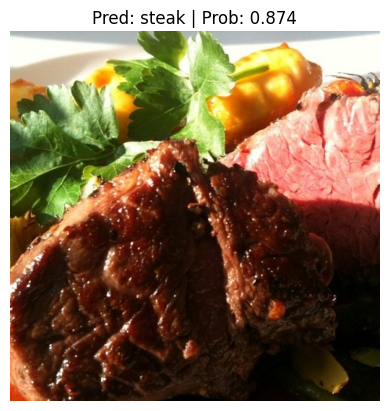

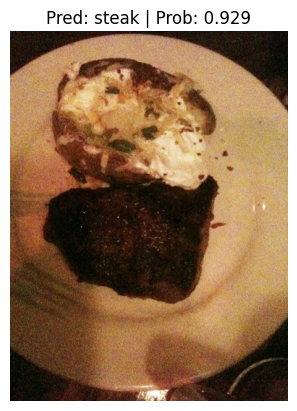

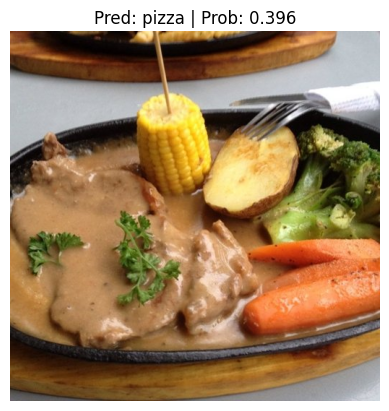

In [44]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

#### 9.1 Predict on a custom image with the best model

data/04-pizza-dad.jpeg already exists, skipping download.


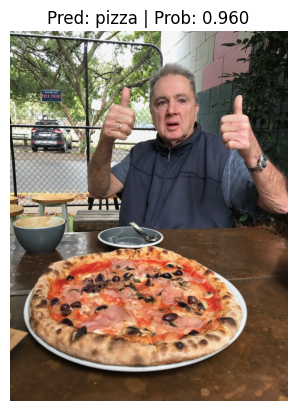

In [45]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)